# This is Estelle's notebook no.2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
# import pytesseract

import requests
from bs4 import BeautifulSoup
import httpx

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [3]:
from PIL import Image
from io import BytesIO

In [4]:
from pokedex.utils_dataset import reduce_dataset, crop_card
from pokedex.augmentation import get_augment_data, transform_array, generate_augmented_image, apply_blur

2024-05-22 15:32:00.861383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reduce dataset function creation

In [60]:
setinfo = np.array(
        [['dv1', '21', 'Dragon Vault', 'right'],
         ['swsh9', '186', 'Brilliant Stars', 'left'],
         ['swsh45', '73', 'Shining Fates', 'left'],
         ['swsh6', '233', 'Chilling Reign', 'left'],
         ['swsh12pt5', '160', 'Crown Zenith', 'left'],
         ['xy1', '146', 'XY', 'right'],
         ['xy2', '110', 'Flashfire', 'right'],
         ['xy3', '114', 'Furious Fists', 'right'],
         ['g1', '117', 'Generations', 'right'],
         ['xy4', '124', 'Phantom Forces', 'right'],
         ['xy6', '112', 'Roaring Skies', 'right'],
         ['xy7', '100', 'Ancient Origins', 'right'],
         ['dp1', '130', 'Diamond & Pearl', 'right'],
         ['dp2', '124', 'Mysterious Treasures', 'right'],
         ['sm4', '126', 'Crimson Invasion', 'left'],
         ['swsh10', '216', 'Astral Radiance', 'left'],
         ['sv4', '266', 'Paradox Rift', 'left'],
         ['sv3pt5', '207', '151', 'left'],
         ['sv3', '230', 'Obsidian Flames', 'left'],
         ['sv2', '279', 'Paldea Evolved', 'left']])

In [61]:
df = pd.read_json('../raw_data/dict_dataset_full.json')
df['corner']=[np.array(v) for v in df['corner']]

In [195]:
setinfo_left = setinfo[setinfo[:,3] == 'left']
setinfo_right = setinfo[setinfo[:,3] == 'right']

In [283]:
set_list = setinfo_right[:,0]
set_list = np.append(set_list, 'no') 
# set_list[-1] = 'no'
set_list

array(['dv1', 'xy1', 'xy2', 'xy3', 'g1', 'xy4', 'xy6', 'xy7', 'dp1',
       'dp2', 'no'], dtype='<U20')

In [306]:
nb_cards = np.array([sum((df['set_id'] == set_list[i]) & (df['position'] == 'right')) for i in range(set_list.shape[0])])

set_to_dropcards = np.vstack((set_list[nb_cards > 150], nb_cards[nb_cards > 150]))
set_to_dropcards

array([['no'],
       ['1974']], dtype='<U21')

In [311]:
df_small = pd.DataFrame()

for i in range(set_to_dropcards.shape[1]):
    idx = np.random.randint(0, high=int(set_to_dropcards[1,i]), size=150, dtype=int)
    # df_small = df[df['set_id'] == set_to_dropcards[0,i]].iloc[idx]
    df_small = pd.concat([ df_small, df[(df['set_id'] == set_to_dropcards[0,i]) & (df['position'] == 'right')].iloc[idx] ], axis=0, ignore_index=True)


In [318]:
for i in range(len(set_list[nb_cards <= 150])):
    df_small = pd.concat([ df_small, df[df['set_id'] == set_list[nb_cards <= 150][i]] ], axis=0, ignore_index=True)

In [317]:
df_small

,corner,position,set_id,set_name
0,"[[145, 145, 145, 145, 145, 145, 145, 145, 145,...",right,no,no
1,"[[154, 154, 154, 154, 154, 154, 154, 154, 154,...",right,no,no
2,"[[191, 191, 191, 191, 191, 191, 191, 191, 191,...",right,no,no
3,"[[154, 154, 154, 154, 154, 154, 154, 154, 154,...",right,no,no
4,"[[154, 154, 154, 154, 154, 154, 154, 154, 154,...",right,no,no
...,...,...,...,...
1203,"[[198, 198, 198, 199, 199, 200, 200, 200, 202,...",right,dp2,Mysterious Treasures
1204,"[[156, 155, 156, 157, 153, 145, 138, 135, 127,...",right,dp2,Mysterious Treasures
1205,"[[130, 129, 126, 121, 115, 110, 109, 109, 105,...",right,dp2,Mysterious Treasures
1206,"[[133, 121, 126, 120, 119, 121, 107, 110, 91, ...",right,dp2,Mysterious Treasures


In [62]:
reduce_dataset()

## Work with left and right dataset

In [34]:
# df_right = pd.read_json('../raw_data/dict_reduceddataset_right.json')
# df_left = pd.read_json('../raw_data/dict_reduceddataset_left.json')

In [17]:
df_right = get_augment_data('../../raw_data/dict_reduceddataset_right.json')

### Split data into train and validation

In [18]:
df_right.shape

(3300, 4)

In [19]:
df_right = shuffle(df_right).reset_index(drop=True)

In [20]:
df_right

,corner,position,set_id,set_name
0,"[[[[176], [189], [189], [189], [177], [168], [...",right,g1,Generations
1,"[[[104], [105], [107], [112], [117], [124], [1...",right,dv1,Dragon Vault
2,"[[[203], [203], [203], [203], [203], [203], [2...",right,xy1,XY
3,"[[[173], [172], [170], [167], [166], [166], [1...",right,xy3,Furious Fists
4,"[[[[159], [153], [153], [153], [153], [176], [...",right,xy7,Ancient Origins
...,...,...,...,...
3295,"[[[180], [180], [180], [180], [181], [181], [1...",right,xy7,Ancient Origins
3296,"[[[[112], [104], [104], [104], [104], [117], [...",right,xy2,Flashfire
3297,"[[[190], [191], [193], [195], [197], [198], [1...",right,xy4,Phantom Forces
3298,"[[[167], [167], [168], [169], [170], [172], [1...",right,dp2,Mysterious Treasures


In [21]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to your column
label_encoder.fit(df_right['set_id'])

# Transform the column
df_right['target'] = label_encoder.transform(df_right['set_id'])

In [22]:
nb_split = int(df_right.shape[0]*0.8)
nb_split

2640

In [23]:
dfr_train = df_right.iloc[:nb_split]
dfr_val = df_right.iloc[nb_split:]

In [24]:
y_train = dfr_train.loc[:,'target']
y_train.shape
y_val = dfr_val.loc[:,'target']
y_val.shape

(660,)

In [25]:
X_train = dfr_train.loc[:,'corner']
X_train[0].shape

(1, 72, 184, 1)

In [26]:
XX_train = np.empty((nb_split, 72, 184, 1))
for i, x in enumerate(X_train):
    XX_train[i,:,:,:] = x

XX_train.shape

(2640, 72, 184, 1)

In [27]:
X_val = dfr_val.loc[:,'corner']
XX_val = np.empty((3300 - nb_split, 72, 184, 1))
for i, x in enumerate(X_val):
    XX_val[i,:,:,:] = x

XX_val.shape

(660, 72, 184, 1)

## Model baseline

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
# ——— CNN Version III:

# - Integrate Preprocessing Layers
# - Add Regularization

model_pipe = Sequential([
    layers.Reshape((72, 184, 1), input_shape=(72,184)),
    layers.Rescaling(scale=1./255.),
    
    layers.Conv2D(32, (5,5), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(32, (3,3), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(11, activation='softmax')
])


In [36]:
model_pipe.compile(loss='sparse_categorical_crossentropy', # No need to OHE target
                   optimizer='adam',
                   metrics=['accuracy'])

In [37]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model_pipe.fit(XX_train, y_train,
               epochs=10, # Use early stopping in practice
               batch_size=32,
               validation_data=(XX_val, y_val),
               verbose=1)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.2954 - loss: 2.0502 - val_accuracy: 0.7167 - val_loss: 0.7793
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8125 - loss: 0.5961 - val_accuracy: 0.9045 - val_loss: 0.3141
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.9339 - loss: 0.2467 - val_accuracy: 0.9515 - val_loss: 0.1613
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.9683 - loss: 0.1073 - val_accuracy: 0.9652 - val_loss: 0.1217
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.9912 - loss: 0.0479 - val_accuracy: 0.9697 - val_loss: 0.0953
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.9918 - loss: 0.0348 - val_accuracy: 0.9515 - val_loss: 0.1546
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.9914 - loss: 0.0302 - val_accuracy: 0.9697 - val_loss: 0.0939
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.9953 - loss: 0.0227 - val_accu

# Left side

In [56]:
width = 200
height = 72

In [6]:
df_left = get_augment_data('../../raw_data/dict_reduceddataset_left.json')

In [7]:
df_left = shuffle(df_left).reset_index(drop=True)

In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to your column
label_encoder.fit(df_left['set_id'])

# Transform the column
df_left['target'] = label_encoder.transform(df_left['set_id'])

In [13]:
categories = to_categorical(df_left['target'])

In [14]:
categories.shape

(3300, 11)

In [112]:
nb_split1 = int(df_left.shape[0]*0.7)
nb_split2 = int(df_left.shape[0]*0.85)

In [115]:
nb_split1

2310

In [117]:
df_left.shape[0]

3300

In [113]:
XX_val = np.empty((nb_split2 - nb_split1, 72, 200, 1))

In [114]:
XX_val.shape

(495, 72, 200, 1)

In [64]:
nb_split = int(df_left.shape[0]*0.8)

dfr_train = df_left.iloc[:nb_split]
dfr_val = df_left.iloc[nb_split:]

In [65]:
y_train = categories[:nb_split,:]
y_val = categories[nb_split:,:]

In [66]:
y_train.shape

(2640, 11)

In [67]:
# y_train = dfr_train.loc[:,'target']
# y_val = dfr_val.loc[:,'target']


In [109]:
X_train = df_left.loc[:nb_split,'corner']

XX_train = np.empty((nb_split, height, width, 1))
for i, x in enumerate(X_train):
    XX_train[i,:,:, :] = x/255

In [70]:
X_val = dfr_val.loc[:,'corner']

XX_val = np.empty((3300 - nb_split, height, width, 1))
for i, x in enumerate(X_val):
    XX_val[i,:,:,:] = x/255

In [71]:
y_train.shape

(2640, 11)

In [72]:
XX_train.shape

(2640, 72, 200, 1)

In [73]:
model_pipe = Sequential([
    # layers.Reshape((height, width, 1), input_shape=(height,width)),
    # layers.Rescaling(scale=1./255., input_shape=(72,200,1)),
    
    layers.Conv2D(32, (5,5), padding='same', activation="relu", input_shape=(72,200,1)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(32, (3,3), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(11, activation='softmax')
])

In [74]:
model_pipe.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [75]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model_pipe.fit(XX_train, y_train,
               epochs=1, # Use early stopping in practice
               batch_size=16,
               validation_data=(XX_val, y_val),
               verbose=1)

165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 269ms/step - accuracy: 0.2253 - loss: 7.9540 - val_accuracy: 0.5227 - val_loss: 1.3968


In [76]:
model_pipe.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 72, 200, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │    29,491,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,478,435 (337.52 MB)

 Trainable params: 29,492,811 (112.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,985,624 (225.01 MB)

# Predict new card

In [118]:
png_filepath = '../../raw_data/PokemonCards/IMG_1488 copy.jpeg'
png_pil_img = Image.open(png_filepath)

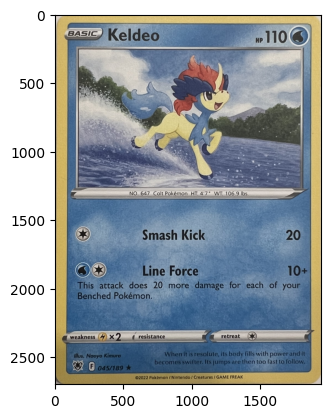

In [119]:
plt.imshow(png_pil_img)

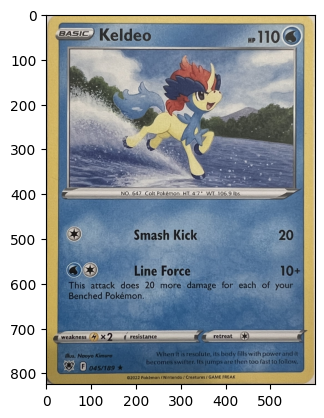

In [124]:
card_image = np.array(png_pil_img)
card_image.shape
new_array = cv2.resize(card_image, (600, 825))
plt.imshow(new_array)

In [85]:
graybottomleft, graybottomright = crop_card(new_array)

In [86]:
graybottomleft = np.expand_dims(graybottomleft, -1)

In [90]:
graybottomleft = np.expand_dims(graybottomleft, 0)

In [106]:
graybottomright = np.expand_dims(graybottomright, -1)
graybottomright = np.expand_dims(graybottomright, 0)
graybottomright.shape

(1, 72, 200, 1)

In [100]:
graybottomleft.shape
# plt.imshow(graybottomleft)

(1, 72, 200, 1)

In [107]:
model_pipe.predict(graybottomright)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.09383262, 0.09990808, 0.09121883, 0.08954186, 0.09202065,
        0.08671126, 0.0860208 , 0.08938437, 0.09473401, 0.08653102,
        0.09009647]], dtype=float32)

In [79]:
df_left = get_augment_data('../../raw_data/dict_reduceddataset_left.json')
df_left = shuffle(df_left).reset_index(drop=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Fit LabelEncoder to your column
label_encoder.fit(df_left['set_id'])
# Transform the column
df_left['category'] = label_encoder.transform(df_left['set_id'])

categories = to_categorical(df_left['category'], num_classes = 11)

nb_split = int(df_left.shape[0]*0.8)

dfl_train = df_left.iloc[:nb_split]
dfl_val = df_left.iloc[nb_split:]

X_train = dfl_train.loc[:,'corner']
X_val = dfl_val.loc[:,'corner']

y_train = categories[:nb_split,:]
y_val = categories[nb_split:,:]

XX_train = np.empty((nb_split, 72, 200, 1))
XX_val = np.empty((3300-nb_split, 72, 200, 1))

for i, x in enumerate(X_train):
    XX_train[i, :, :, 0] = np.array(x).reshape(72, 200)

for i, x in enumerate(X_val):
    XX_val[i, :, :, 0] = np.array(x).reshape(72, 200)

batch_size = 32
nb_classes =11
nb_epochs = 1

model_l = Sequential([
    # layers.Rescaling(scale=1./255., input_shape=(72, 200, 1)),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(72, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(nb_classes, activation='softmax')
])

/Users/estelle/.pyenv/versions/3.10.6/envs/project_pokereader/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model_l.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [88]:
history = model_l.fit(XX_train, y_train,
               epochs=1, # Use early stopping in practice
               batch_size=batch_size,
               validation_data=(XX_val, y_val),
               verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.4245 - loss: 78.7043 - val_accuracy: 0.8742 - val_loss: 0.4479


In [96]:
dummy = np.ones((1,72,200,1))

In [99]:
dummy.shape

(1, 72, 200, 1)

In [101]:
type(dummy)

numpy.ndarray

In [102]:
type(graybottomleft)

numpy.ndarray

In [103]:
model_l.predict(graybottomleft)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.04908708, 0.00091696, 0.02683047, 0.04325988, 0.0173332 ,
        0.06719786, 0.0029609 , 0.52384233, 0.00442842, 0.09336381,
        0.17077914]], dtype=float32)